In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_log_error as rmsle
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import KFold
import xgboost as xgb
import seaborn as sns
import itertools

In [2]:
train = pd.read_csv("train_comp.csv")
test = pd.read_csv("test_comp.csv")
# sample = pd.read_csv("sample_submission.csv")

train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189,82,26,101,41.0,150
1,female,64,163,60,8,85,39.7,34
2,female,51,161,64,7,84,39.8,29
3,male,20,192,90,25,105,40.7,140
4,female,38,166,61,25,102,40.6,146


In [3]:
numerical_features = ["Age","Height","Weight","Duration","Heart_Rate","Body_Temp"]

def add_feats(df, numerical_features):
    ''''''''''
    Inputs: dataframe df
    Output: the modified dataframe with cross terms, BMI, id+calories removed, and sex as categorical variable
    '''''''''
    df_new = df.copy()

    features = df_new.columns

    if 'id' in features:
        df_new = df_new.drop(columns=['id'])
    
    if 'Calories' in features:
        df_new = df_new.drop(columns=['Calories'])
    
    
    df_new['Sex'] = df_new['Sex'].astype('category')

    df_new['BMI'] = df_new['Weight']/((df_new['Height']/100)**2)

    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):  
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]
            #cross_term_name = f"{feature1}_divided_{feature2}"
            #df_new[cross_term_name] = df_new[feature1] / df_new[feature2]

    return df_new

In [4]:
y = np.log1p(train['Calories'])

X = add_feats(train, numerical_features)

X.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Age_x_Height,Age_x_Weight,...,Height_x_Weight,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp
0,male,36,189,82,26,101,41.0,22.955684,6804,2952,...,15498,4914,19089,7749.0,2132,8282,3362.0,2626,1066.0,4141.0
1,female,64,163,60,8,85,39.7,22.582709,10432,3840,...,9780,1304,13855,6471.1,480,5100,2382.0,680,317.6,3374.5
2,female,51,161,64,7,84,39.8,24.690405,8211,3264,...,10304,1127,13524,6407.8,448,5376,2547.2,588,278.6,3343.2
3,male,20,192,90,25,105,40.7,24.414062,3840,1800,...,17280,4800,20160,7814.4,2250,9450,3663.0,2625,1017.5,4273.5
4,female,38,166,61,25,102,40.6,22.136740,6308,2318,...,10126,4150,16932,6739.6,1525,6222,2476.6,2550,1015.0,4141.2


In [6]:
max_depth = [10, 12]
learning_rate = [0.1, 0.05]
number_boosts = [100, 200]
subsamp = [0.75, 0.9, 1]

model_err = {}

for md, lr, nbr, ss in itertools.product(max_depth, learning_rate, number_boosts, subsamp):
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True)

    # Initialize a list to collect accuracy scores
    scores = []

    # Iterate over each fold
    for train_index, test_index in kf.split(X):

        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True) 

                
        # Define parameters
        params = {
            'max_depth': md,
            'eta': lr,                           # learning rate
            'objective': 'reg:squarederror',     # 
            'eval_metric': 'rmse',
            'subsample': ss,                     # subsample rate
            'device': 'cuda'
        }

        # Initialize and train the model
        model = xgb.train(params, dtrain, num_boost_round=nbr,
                          evals=[(dtrain, 'train'), (xgb.DMatrix(X_test, label=y_test, enable_categorical=True), 'eval')], early_stopping_rounds=25, verbose_eval=False)


        # Predict and evaluate the model
        y_pred = model.predict(xgb.DMatrix(X_test, enable_categorical=True))
        y_pred[y_pred <= 0] = 10
        score = rmse(y_test, y_pred)
        scores.append(score)

            
    # Output the mean accuracy over all folds
    print(f"Mean Accuracy for max_depth={md}, learn_rate={lr}, num_boost={nbr}, subsample={ss}: {np.mean(scores)}")

    model_err[f"max_depth_{md}_learn_rate_{lr}_num_boost_{nbr}_subsample_{ss}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

Mean Accuracy for max_depth=10, learn_rate=0.1, num_boost=100, subsample=0.75: 0.06075632834839817
Mean Accuracy for max_depth=10, learn_rate=0.1, num_boost=100, subsample=0.9: 0.06058865525795841
Mean Accuracy for max_depth=10, learn_rate=0.1, num_boost=100, subsample=1: 0.060736706586758796
Mean Accuracy for max_depth=10, learn_rate=0.1, num_boost=200, subsample=0.75: 0.06079437680245001
Mean Accuracy for max_depth=10, learn_rate=0.1, num_boost=200, subsample=0.9: 0.06080382481313329
Mean Accuracy for max_depth=10, learn_rate=0.1, num_boost=200, subsample=1: 0.06077575259164873
Mean Accuracy for max_depth=10, learn_rate=0.05, num_boost=100, subsample=0.75: 0.060876656310991595
Mean Accuracy for max_depth=10, learn_rate=0.05, num_boost=100, subsample=0.9: 0.06072298557056843
Mean Accuracy for max_depth=10, learn_rate=0.05, num_boost=100, subsample=1: 0.06103689377664482
Mean Accuracy for max_depth=10, learn_rate=0.05, num_boost=200, subsample=0.75: 0.06037333180586988
Mean Accuracy fo

In [7]:
max_depth = [8, 10]
learning_rate = [0.1, 0.05]
number_boosts = [150, 200, 250]
subsamp = [0.75, 0.9]

model_err = {}

for md, lr, nbr, ss in itertools.product(max_depth, learning_rate, number_boosts, subsamp):
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True)

    # Initialize a list to collect accuracy scores
    scores = []

    # Iterate over each fold
    for train_index, test_index in kf.split(X):

        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True) 

                
        # Define parameters
        params = {
            'max_depth': md,
            'eta': lr,                           # learning rate
            'objective': 'reg:squarederror',     # 
            'eval_metric': 'rmse',
            'subsample': ss,                     # subsample rate
            'device': 'cuda'
        }

        # Initialize and train the model
        model = xgb.train(params, dtrain, num_boost_round=nbr,
                          evals=[(dtrain, 'train'), (xgb.DMatrix(X_test, label=y_test, enable_categorical=True), 'eval')], early_stopping_rounds=25, verbose_eval=False)


        # Predict and evaluate the model
        y_pred = model.predict(xgb.DMatrix(X_test, enable_categorical=True))
        y_pred[y_pred <= 0] = 10
        score = rmse(y_test, y_pred)
        scores.append(score)

            
    # Output the mean accuracy over all folds
    print(f"Mean Accuracy for max_depth={md}, learn_rate={lr}, num_boost={nbr}, subsample={ss}: {np.mean(scores)}")

    model_err[f"max_depth_{md}_learn_rate_{lr}_num_boost_{nbr}_subsample_{ss}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

Mean Accuracy for max_depth=8, learn_rate=0.1, num_boost=150, subsample=0.75: 0.06056078640211857
Mean Accuracy for max_depth=8, learn_rate=0.1, num_boost=150, subsample=0.9: 0.06061870518507144
Mean Accuracy for max_depth=8, learn_rate=0.1, num_boost=200, subsample=0.75: 0.06070156832074709
Mean Accuracy for max_depth=8, learn_rate=0.1, num_boost=200, subsample=0.9: 0.06071038543243716
Mean Accuracy for max_depth=8, learn_rate=0.1, num_boost=250, subsample=0.75: 0.06071848041450817
Mean Accuracy for max_depth=8, learn_rate=0.1, num_boost=250, subsample=0.9: 0.06059276409682783
Mean Accuracy for max_depth=8, learn_rate=0.05, num_boost=150, subsample=0.75: 0.06024944336235401
Mean Accuracy for max_depth=8, learn_rate=0.05, num_boost=150, subsample=0.9: 0.06050437915784966
Mean Accuracy for max_depth=8, learn_rate=0.05, num_boost=200, subsample=0.75: 0.06035656913977204
Mean Accuracy for max_depth=8, learn_rate=0.05, num_boost=200, subsample=0.9: 0.060312404960457845
Mean Accuracy for ma

In [ ]:
max_depth = [6, 8]
learning_rate = [0.1, 0.05]
number_boosts = [125, 150, 175]
subsamp = [0.75, 0.9]

model_err = {}

for md, lr, nbr, ss in itertools.product(max_depth, learning_rate, number_boosts, subsamp):
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True)

    # Initialize a list to collect accuracy scores
    scores = []

    # Iterate over each fold
    for train_index, test_index in kf.split(X):

        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True) 

                
        # Define parameters
        params = {
            'max_depth': md,
            'eta': lr,                           # learning rate
            'objective': 'reg:squarederror',     # 
            'eval_metric': 'rmse',
            'subsample': ss,                     # subsample rate
            'device': 'cuda'
        }

        # Initialize and train the model
        model = xgb.train(params, dtrain, num_boost_round=nbr,
                          evals=[(dtrain, 'train'), (xgb.DMatrix(X_test, label=y_test, enable_categorical=True), 'eval')], early_stopping_rounds=25, verbose_eval=False)


        # Predict and evaluate the model
        y_pred = model.predict(xgb.DMatrix(X_test, enable_categorical=True))
        y_pred[y_pred <= 0] = 1
        score = rmse(y_test, y_pred)
        scores.append(score)

            
    # Output the mean accuracy over all folds
    print(f"Mean Accuracy for max_depth={md}, learn_rate={lr}, num_boost={nbr}, subsample={ss}: {np.mean(scores)}")

    model_err[f"max_depth_{md}_learn_rate_{lr}_num_boost_{nbr}_subsample_{ss}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

Mean Accuracy for max_depth=6, learn_rate=0.1, num_boost=125, subsample=0.75: 0.06126157571950615
Mean Accuracy for max_depth=6, learn_rate=0.1, num_boost=125, subsample=0.9: 0.061212125663776484
Mean Accuracy for max_depth=6, learn_rate=0.1, num_boost=150, subsample=0.75: 0.06105484276171047
Mean Accuracy for max_depth=6, learn_rate=0.1, num_boost=150, subsample=0.9: 0.06117718433591949
Mean Accuracy for max_depth=6, learn_rate=0.1, num_boost=175, subsample=0.75: 0.06105633910305232
Mean Accuracy for max_depth=6, learn_rate=0.1, num_boost=175, subsample=0.9: 0.060972824860646715
Mean Accuracy for max_depth=6, learn_rate=0.05, num_boost=125, subsample=0.75: 0.06171521158051221
Mean Accuracy for max_depth=6, learn_rate=0.05, num_boost=125, subsample=0.9: 0.06177706618274492
Mean Accuracy for max_depth=6, learn_rate=0.05, num_boost=150, subsample=0.75: 0.06158580128704151
Mean Accuracy for max_depth=6, learn_rate=0.05, num_boost=150, subsample=0.9: 0.061332011954011036
Mean Accuracy for 

0.055834218318237934


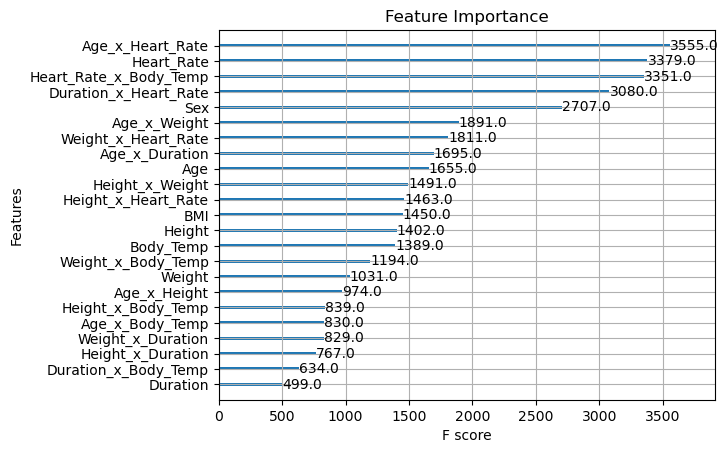

In [ ]:
# Kaggle score 0.05856, xgb_prediction_11.csv, max depth 8, learning rate 0.05, early_stopping_rounds 25, subsample 0.75

num_indices = 600000

train_index = np.random.choice(X.index, size=num_indices, replace=False)
test_index = list(set(np.arange(len(X))) - set(train_index))


X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

# Define parameters
params = {
            'max_depth': 8,
            'eta': 0.05,                         # learning rate
            'objective': 'reg:squarederror',     
            'eval_metric': 'rmse',
            'subsample': 0.75,                   # subsample rate
            'device': 'cuda'
         }

# Initialize and train the model
model = xgb.train(params, dtrain, num_boost_round=nbr,
                     evals=[(dtrain, 'train'), (xgb.DMatrix(X_test, label=y_test, enable_categorical=True), 'eval')], early_stopping_rounds=25, verbose_eval=False)


# Make predictions
y_pred = model.predict(xgb.DMatrix(X_test, enable_categorical=True))
y_pred[y_pred <= 0] = 1
print(rmse(y_test, y_pred))


# Get feature importance scores
# By default or in this example, the importance type is 'weight' - frequency that the feature is used
importance = model.get_score(importance_type='weight')

# Sort the importance dictionary by importance value
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)


# Plot feature importance using xgboost's built-in plot_importance
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

In [10]:
test_mod = add_feats(test, numerical_features)

test_mod.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Age_x_Height,Age_x_Weight,...,Height_x_Weight,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp
0,male,45,177,81,7,87,39.8,25.854639,7965,3645,...,14337,1239,15399,7044.6,567,7047,3223.8,609,278.6,3462.6
1,male,26,200,97,20,101,40.5,24.250000,5200,2522,...,19400,4000,20200,8100.0,1940,9797,3928.5,2020,810.0,4090.5
2,female,29,188,85,16,102,40.4,24.049344,5452,2465,...,15980,3008,19176,7595.2,1360,8670,3434.0,1632,646.4,4120.8
3,female,39,172,73,20,107,40.6,24.675500,6708,2847,...,12556,3440,18404,6983.2,1460,7811,2963.8,2140,812.0,4344.2
4,female,30,173,67,16,94,40.5,22.386314,5190,2010,...,11591,2768,16262,7006.5,1072,6298,2713.5,1504,648.0,3807.0


In [16]:
# make the submission file!

pred = model.predict(xgb.DMatrix(test_mod, enable_categorical=True))

submission = pd.DataFrame()

submission['id'] = np.arange(len(test_mod))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1

submission.to_csv("xgb_prediction_11.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

       id    Calories
0  750000   27.713531
1  750001  108.366646
2  750002   86.711281
3  750003  126.551628
4  750004   75.386971

count    250000.000000
mean         88.165627
std          62.244732
min           0.988741
25%          34.030233
50%          76.443623
75%         135.467133
max         295.114380
Name: Calories, dtype: float64
